# Trabajo Práctico - Organización de Datos
## Parte 1 - Análisis de datos
- Continanza, Nicolás (97576)
- De Angelis Riva, Lukas Nahuel  (103784)

#### FIUFIP: Que No Se Escape Nadie (?)

A partir de la información recolectada por FIUFIP, queremos hacer un análisis que nos permita inferir qué ciudadanos tienen un alto poder adquisitivo. Para esto, y tomando en cuenta la información con la que contamos y sus limitaciones, creemos que será valioso poder responder las siguientes preguntas, y evaluar si nos aportan información útil:

1. ¿Cuántas personas tienen un alto poder adquisitivo en los datos recolectados por la agencia?
2. ¿Hay alguna relación entre la edad de las personas encuestadas y su poder adquisitivo?
3. ¿Existe un cambio notable en la respuesta a la pregunta anterior si separamos la muestra por género?
4. Respondiendo las tres preguntas anteriores podríamos encontrar una relación entre las variables edad y género, y sería interesante saber qué tan similar o disímil es la variable edad entre los tipos de trabajo que realizan. Entonces, ¿Cómo se distribuye la edad de las personas encuestadas según su trabajo?
6. ¿Qué se puede decir sobre los tipos de sala más elegidos separando a los encuestados por edad?
7.
8.

## Imports y puesta en escena

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
import matplotlib

import numpy as np

GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)
TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))

Para empezar, utilizamos la función feature_engineering a la que llegamos en `haciendoUnPocoDeIngenieria.ipynb` tras analizar las características del dataset.

In [3]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

In [4]:
df = feature_engineering(df)

# Información previa

Del Notebook anterior nos llevamos la información de que la mejor primera estimación sobre el valor adquisitivo de las personas están dados por los atributos de bolsa y anios_estudiados

# Condicionando por bolsa

Tendremos entonces 3 data sets diferentes, la gente que ganó, la gente que perdió y la gente con neto 0.

In [36]:
def determinar_categoria_en_bolsa(accion_en_bolsa):
    if(accion_en_bolsa > 0):
        return 'Ganancia'
    elif(accion_en_bolsa < 0):
        return 'Pérdida'
    else:
        return 'Nada'

df_bolsa = df.copy()
df_bolsa['bolsa'] = df_bolsa['ganancia_perdida_declarada_bolsa_argentina'].apply(determinar_categoria_en_bolsa)
del df_bolsa['ganancia_perdida_declarada_bolsa_argentina']

df_ganancia = df[df['ganancia_perdida_declarada_bolsa_argentina'] > 0].copy()
df_perdida = df[df['ganancia_perdida_declarada_bolsa_argentina'] < 0].copy()
df_nada = df[df['ganancia_perdida_declarada_bolsa_argentina'] == 0].copy()

De ahora en más los gráficos y decisiones que tomemos serán en base a si tuvo ganancia, pérdida o si no accionó en la bolsa.

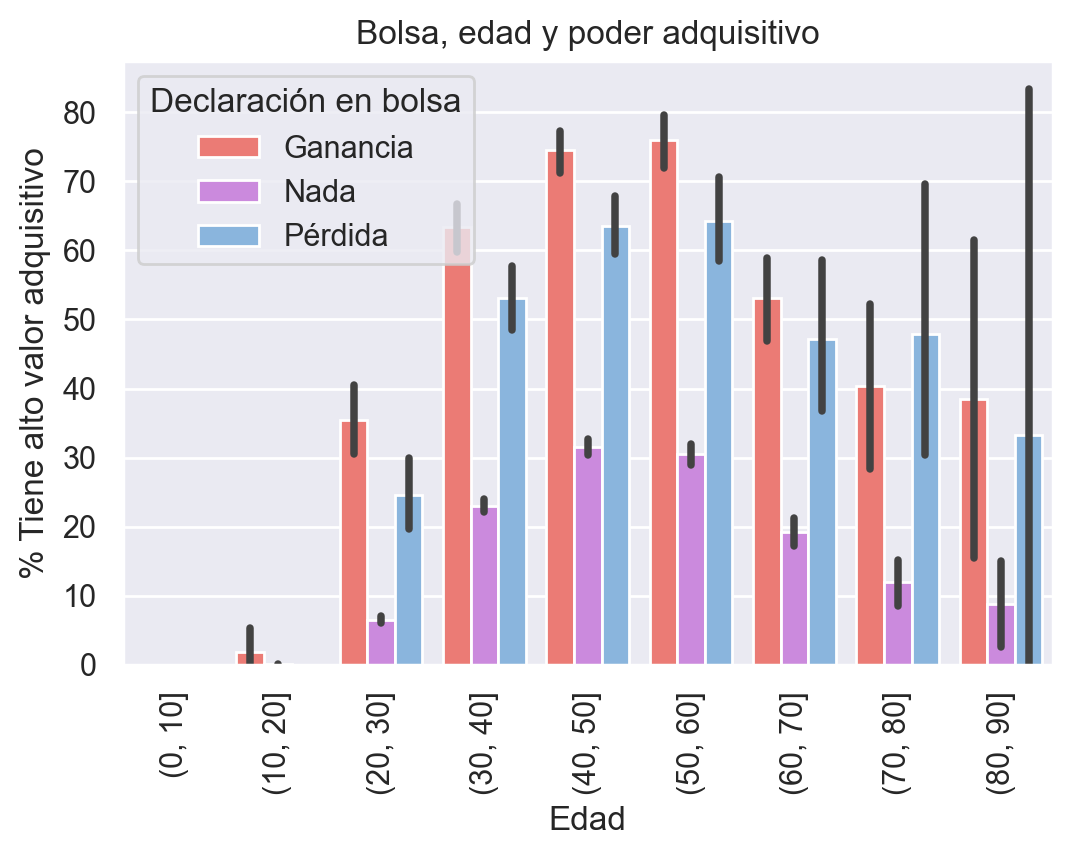

In [49]:
df_tmp = df_bolsa.copy()

df_tmp['bins'] = pd.cut(df_tmp.edad, range(0, int(df_tmp['edad'].max()) + 10,10))
# Configuro el grafico, armo el countplot y setteo labels varios
plt.figure(dpi=200)
sns.barplot(
    data=df_tmp,
    x='bins',
    y='tiene_alto_valor_adquisitivo',
    hue='bolsa',
    palette=['#FF6961', '#D37CEB', '#7CB6EB'],
    estimator=lambda x: np.mean(x)*100.0)

#sns.barplot(x="bins", hue="bolsa", y="tiene_alto_valor_adquisitivo", data=df_tmp)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Edad")
plt.xticks(rotation=90)
plt.title('Bolsa, edad y poder adquisitivo')
plt.legend(title='Declaración en bolsa')
plt.show()


Es notable observar que la gente que invierte en bolsa (ganancia o pérdida) obtiene un boost interesante en edades intermedias (entre 30 y 70 años) provocando que la proporción de gente con alto poder adquisitivo en estas etapas siga siendo notable.

Veamos ahora si esto incrementa nuestro accuracy

In [51]:
def por_edad_y_bolsa(row):
    if(row['bolsa'] == 'Nada'):
        return 0
    elif(row['edad'] > 30 and row['edad'] < 70):
        return 1
    else:
        return 0
indice = np.mean(df['tiene_alto_valor_adquisitivo'] == df_bolsa.apply(func=por_edad_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 79.1%


El porcentaje de aciertos aumenta, pero prácticamente nada, esto es debido a que no pudimos filtrar correctamente la gente con poder adquisitivo alto que cayó en "Nada". Que son muchos más.